In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import glob
import sys

from math import *
import pickle

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable

from IPython import display
import time

from PIL import Image

import copy
import subprocess as sp

def tovar(x):
    return torch.cuda.FloatTensor(x)

def toivar(x):
    return torch.cuda.LongTensor(x)

In [3]:
class EVL(nn.Module):
    def __init__(self, noise_d = 16, width = 256, d=1):
        super(EVL,self).__init__()
        
        self.l1 = nn.Conv1d(noise_d, width, 1)
        nn.init.orthogonal_(self.l1.weight, gain=sqrt(2))
        self.l2 = nn.Conv1d(width, width, 1)
        nn.init.orthogonal_(self.l2.weight, gain=sqrt(2))
        self.l3 = nn.Conv1d(width, width, 1)
        nn.init.orthogonal_(self.l3.weight, gain=sqrt(2))
        self.l4 = nn.Conv1d(width, width, 1)
        nn.init.orthogonal_(self.l4.weight, gain=sqrt(2))
        self.l5 = nn.Conv1d(width, width, 1)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        self.l6 = nn.Conv1d(width, d+1, 1)
        
        self.optim = torch.optim.RMSprop(self.parameters(), lr=5e-4)
        self.schedule = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=0.95)
        
        self.d = d
        
    def forward(self, x):
        z = F.relu(self.l1(x))
        z = F.relu(self.l2(z))
        z = F.relu(self.l3(z))
        z = F.relu(self.l4(z))
        z = F.relu(self.l5(z))
        z = self.l6(z)
        
        y = z[:,0:self.d,:]
        p = F.log_softmax(z[:,self.d,:], dim=1)
        
        return y,p

In [4]:
def mkDataset(N=1, d=1, seed=1, pts=5000):
    np.random.seed(seed)
    mu = np.random.rand(N,d)*12-6

    idx = np.random.randint(N, size=(pts,))

    return np.random.randn(pts,d) + mu[idx], mu

In [5]:
def addSubData(hist, x, p, dim, maxdim, N, idx):
    if dim<maxdim:
        xidx = np.clip((N*(x[:,dim]+12)/24), 0, N-1).astype(np.int32)
        for i in range(N):
            keep = xidx == i
            addSubData(hist, x[keep], p[keep], dim+1, maxdim, N, idx + i*(N**dim))
    else:
        hist[idx] = np.sum(p)

def estimate_Nd_KL(x, y, p, N=20):
    d = x.shape[1]

    histx = np.zeros((N**d))
    histy = np.zeros((N**d))
    
    addSubData(histx, x, np.ones(x.shape[0]), 0, d, N, 0)

    addSubData(histy, y, p, 0, d, N, 0)

    histx = histx / np.sum(histx)
    histy = histy / np.sum(histy)
    
    fisher = 2*acos(np.sum(np.sqrt(histx*histy)))
    
    nonzero = (histx>0)
    histx = histx[nonzero]
    histy = histy[nonzero]
    
    histy = histy + 1e-32
    histy = histy / np.sum(histy)
    histx = histx / np.sum(histx)

    KL = -np.sum(histx*np.log(histy/histx))

    return KL, fisher  

In [6]:
def EVLScaling(ndata = 50000, d=1, N=1, seed=1):
    BS = 200

    evl = EVL(width=256, d=d).cuda()
    errs = []
    KL = []
    Fisher = []
    
    xall, mu = mkDataset(N=N, d=d, seed=seed, pts=ndata + 400000)

    xtrain = xall[0:ndata]
    xtest = xall[ndata:]

    x = tovar(xtrain)

    idx = torch.arange(BS).long().cuda()

    for epoch in range(50):
        err = []
        for i in range(x.size(0)//BS):    
            evl.zero_grad()
            n = torch.zeros(BS, 16, 128).cuda()
            n.normal_()

            y,p = evl.forward(n)

            loss = torch.mean((y-x[i*BS:i*BS+BS].unsqueeze(2))**2,1)
            loss, lidx = torch.min(loss, 1)

            ploss = -torch.mean(p[idx, lidx[idx]])

            tloss = torch.mean(loss) + ploss
            tloss.backward()

            err.append(tloss.cpu().detach().item())
            evl.optim.step()
            
        evl.schedule.step()

        if epoch%10==9:
            errs.append(np.mean(err))
            y = np.zeros((0,xall.shape[1]))
            p = np.zeros((0,))

            for i in range(4):
                n = torch.zeros(1, 16, 100000).cuda()
                n.normal_()
                yy,pp = evl.forward(n)

                yy = yy.cpu().detach().numpy()[0].transpose(1,0)
                pp = torch.exp(pp).cpu().detach().numpy()[0]
                y = np.concatenate([y,yy],axis=0)
                p = np.concatenate([p,pp],axis=0)

            kld, f = estimate_Nd_KL(xtest,y,p)
            KL.append(kld)
            Fisher.append(f)

            plt.clf()
            plt.subplot(1,2,1)
            plt.plot(errs)

            plt.subplot(1,2,2)
            plt.plot(KL)
            plt.yscale("log")

            plt.gcf().set_size_inches((16,8))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.01)
  
    emp_kl, emp_f = estimate_Nd_KL(xtest, xall[0:ndata], np.ones(ndata))
    return KL[-1], np.min(KL), emp_kl, Fisher[-1], np.min(Fisher), emp_f

In [7]:
class metaLinear(nn.Module):
    def __init__(self, Nin, Nout):
        super(metaLinear,self).__init__()
        
        self.betaW = Parameter(torch.FloatTensor(np.ones(1)*5e-3))
        self.betaB = Parameter(torch.FloatTensor(np.ones(1)*5e-3))
        
        self.layer = nn.Linear(Nin, Nout)
        nn.init.orthogonal_(self.layer.weight, gain=sqrt(2))
    
    def forward(self, x, meta=False):
        if meta:
            return F.linear(x,
                            weight=self.layer.weight + self.dweight, 
                            bias=self.layer.bias + self.dbias)
        else:
            self.dweight = torch.zeros_like(self.layer.weight)
            self.dbias = torch.zeros_like(self.layer.bias)
        
            return F.linear(x,
                            weight=self.layer.weight, 
                            bias=self.layer.bias)
    
    def update(self, loss):
        gradW, gradB = torch.autograd.grad([loss], [self.layer.weight, self.layer.bias], 
                                           retain_graph=True, create_graph=True)
        gradW = gradW.detach()
        gradB = gradB.detach()
        self.dweight = (self.dweight - self.betaW[0] * gradW)
        self.dbias = (self.dbias - self.betaB[0] * gradB)
        
class Generator(nn.Module):
    def __init__(self, width = 256, noise_d = 16, d=1):
        super(Generator,self).__init__()
        
        self.l1 = nn.Linear(noise_d, width)
        nn.init.orthogonal_(self.l1.weight, gain=sqrt(2))
        self.l2 = nn.Linear(width, width)
        nn.init.orthogonal_(self.l2.weight, gain=sqrt(2))
        self.l3 = nn.Linear(width, width)
        nn.init.orthogonal_(self.l3.weight, gain=sqrt(2))
        self.l4 = nn.Linear(width, width)
        nn.init.orthogonal_(self.l4.weight, gain=sqrt(2))
        self.l5 = nn.Linear(width, width)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        self.l6 = nn.Linear(width, d)
        
        self.optim = torch.optim.RMSprop(self.parameters(), lr=1e-3)
        self.schedule = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma = 0.99)
        
        self.d = d
        
    def forward(self, x):
        z = F.relu(self.l1(x))
        z = F.relu(self.l2(z))
        z = F.relu(self.l3(z))
        z = F.relu(self.l4(z))
        z = F.relu(self.l5(z))
        z = self.l6(z)
                
        return z
    
class Discriminator(nn.Module):
    def __init__(self, width = 256, d=1):
        super(Discriminator,self).__init__()
        
        self.l1 = metaLinear(d, width)
        self.l2 = metaLinear(width, width)
        self.l3 = metaLinear(width, width)
        self.l4 = metaLinear(width, width)
        self.l5 = metaLinear(width, width)
        self.l6 = metaLinear(width, 1)
        
        self.optim = torch.optim.RMSprop(self.parameters(), lr=1e-3)
        self.schedule = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma = 0.95)
        self.d = d
        
    def update(self, loss):
        for layer in self.children():
            if "update" in dir(layer):
                layer.update(loss)
                
    def forward(self, x, meta):
        z = F.relu(self.l1(x), meta)
        z = F.relu(self.l2(z), meta)
        z = F.relu(self.l3(z), meta)
        z = F.relu(self.l4(z), meta)
        z = F.relu(self.l5(z), meta)
        z = self.l6(z, meta)
                
        return z[:,0]

In [8]:
def UnrolledGANScaling(ndata = 50000, d=1, N=1, seed=1):
    BS = 200

    disc = Discriminator(width=32, d=d).cuda()
    gen = Generator(width=32, d=d).cuda()

    errs = []
    KL = []
    Fisher = []

    xall, mu = mkDataset(N=N, d=d, seed=seed, pts=400000+ndata)

    x = tovar(xall[0:ndata])
    xtrue = xall[ndata:]

    idx = torch.arange(BS).long().cuda()
    
    count = 0

    for epoch in range(50):
        # Joint updates    
        for i in range(x.size(0)//BS):
            # Discriminator
            disc.zero_grad()

            xt = x[i*BS:i*BS+BS]
            xf = gen.forward(tovar(np.random.randn(BS, 16)))

            pto = disc.forward(xt, False)
            pfo = disc.forward(xf, False)
            pt = F.sigmoid(pto-torch.mean(pfo))
            pf = F.sigmoid(pfo-torch.mean(pto))

            loss = -torch.mean(torch.log(pt+1e-8)) - torch.mean(torch.log(1-pf+1e-8))
            loss.backward()

            disc.optim.step()

            # Generator
            gen.zero_grad()
            disc.zero_grad()

            for j in range(5):
                xt = x[i*BS:i*BS+BS]
                xf = gen.forward(tovar(np.random.randn(BS, 16)))

                pto = disc.forward(xt, j>0)
                pfo = disc.forward(xf, j>0)
                pt = F.sigmoid(pto-torch.mean(pfo))
                pf = F.sigmoid(pfo-torch.mean(pto))

                dloss = -torch.mean(torch.log(pt+1e-8)) - torch.mean(torch.log(1-pf+1e-8))
                disc.update(dloss)

            gloss = torch.mean(torch.log(pt+1e-8)) + torch.mean(torch.log(1-pf+1e-8))

            gloss.backward()
            gen.optim.step()

        disc.schedule.step()
        gen.schedule.step()
        
        if epoch%10 == 9:
            yy = np.zeros((0,xtrue.shape[1]))
            
            for i in range(4):
                y = gen.forward(tovar(np.random.randn(100000, 16)))
                y = y.cpu().detach().numpy()
                yy = np.concatenate([yy,y],axis=0)

            K, f = estimate_Nd_KL(xtrue,yy,np.ones(yy.shape[0]))
            Fisher.append(f)
            KL.append(K)

            plt.clf()
            plt.subplot(1,3,1)
            plt.hist(xtrue[:,0], 40, range=[-12,12])

            plt.subplot(1,3,2)
            plt.hist(yy[:,0], 40, range=[-12,12])

            plt.subplot(1,3,3)
            plt.plot(KL)
            plt.yscale("log")

            plt.gcf().set_size_inches((15,5))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.01)
    
    emp_kl, emp_f = estimate_Nd_KL(xtrue, xall[0:ndata], np.ones(ndata))
    return KL[-1], np.min(KL), emp_kl, Fisher[-1], np.min(Fisher), emp_f

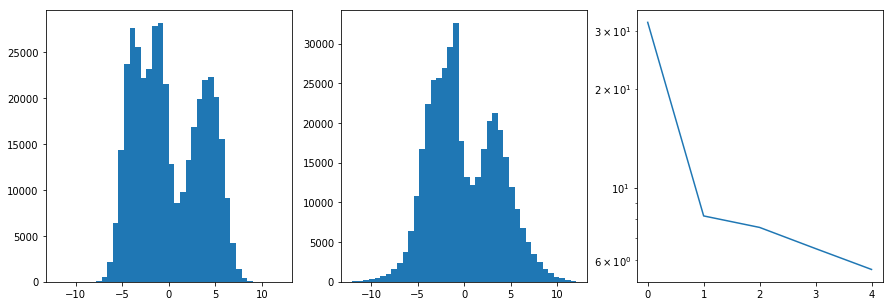

In [ ]:
# Unrolled GAN

Ds = []
for d in range(1,5):
    print("d=%d" % d)
    Ns = []
    for N in [1,2,4,10]:
        print("N=%d" % N)
        pts = []
        for seed in range(1,6):
            Kf, Km, Ekl, FF, Fm, EF = UnrolledGANScaling(d=d,N=N,seed=seed, ndata=5000)            
            pts.append(np.array([Kf, Km, Ekl, FF, Fm, EF]))
        np.savetxt("unrolled_d_%d_N_%d_5k.txt" % (d,N), np.array(pts))
        Ns.append(np.array(pts))
    Ds.append(np.array(Ns))
Ds = np.array(Ds)

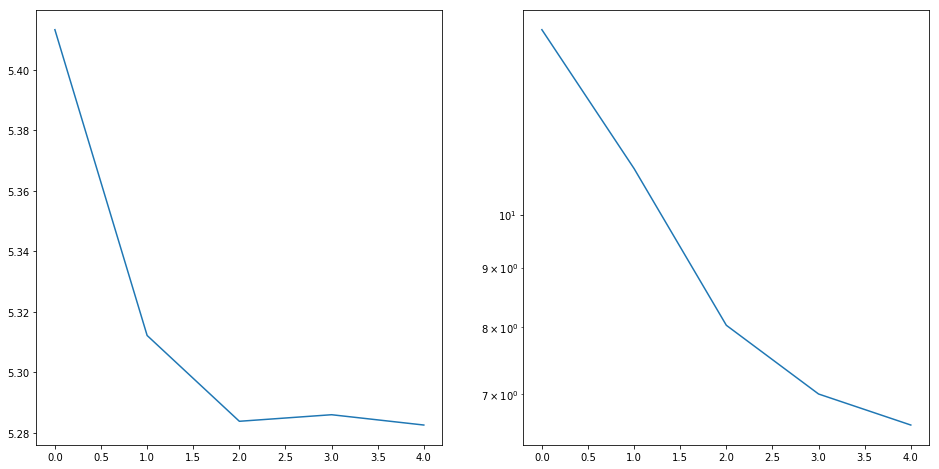

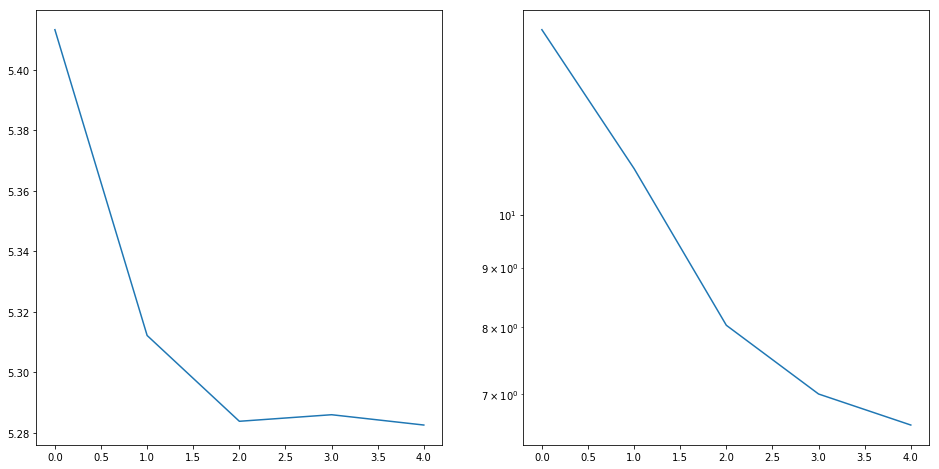

In [21]:
# Extreme value loss

Ds = []
for d in range(1,5):
    print("d=%d" % d)
    Ns = []
    for N in [1,2,4,10]:
        print("N=%d" % N)
        pts = []
        for seed in range(1,6):
            Kf, Km, Ekl, FF, Fm, EF = EVLScaling(d=d,N=N,seed=seed,ndata=5000)
            pts.append(np.array([Kf, Km, Ekl, FF, Fm, EF]))
        np.savetxt("d_%d_N_%d_5k.txt" % (d,N), np.array(pts))
        Ns.append(np.array(pts))
    Ds.append(np.array(Ns))
Ds = np.array(Ds)

In [10]:
from sklearn.datasets import make_swiss_roll

sw_all, _ = make_swiss_roll(450000, noise=0.1)
sw_all = sw_all * 0.5

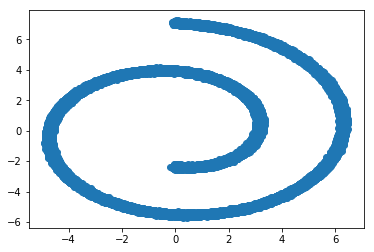

In [11]:
plt.scatter(sw_all[:,0], sw_all[:,2])
plt.show()

In [12]:
sw_all.shape

(450000, 3)

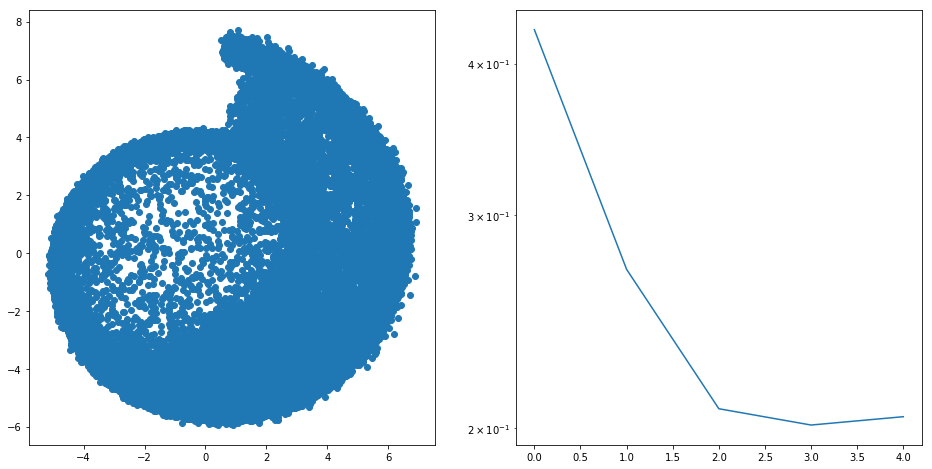

0.2044971528052587 0.20128606283789025 0.05358170566909279 0.4114778000672376 0.4114778000672376 0.12638762053085026


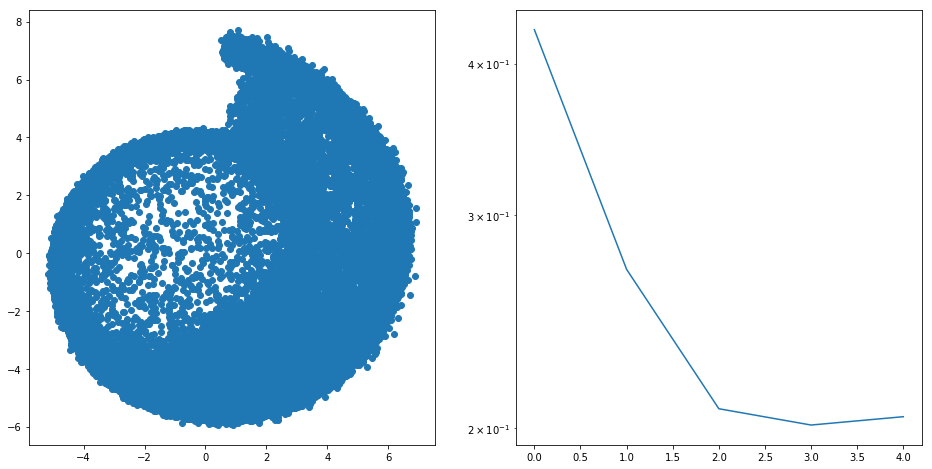

In [13]:
BS = 200

d = 3
evl = EVL(width=256, d=d).cuda()
errs = []
KL = []
Fisher = []

ndata = 50000
xtrain = sw_all[0:ndata]
xtest = sw_all[ndata:]

x = tovar(xtrain)

idx = torch.arange(BS).long().cuda()

for epoch in range(50):
    err = []
    for i in range(x.size(0)//BS):    
        evl.zero_grad()
        n = torch.zeros(BS, 16, 128).cuda()
        n.normal_()

        y,p = evl.forward(n)

        loss = torch.mean((y-x[i*BS:i*BS+BS].unsqueeze(2))**2,1)
        loss, lidx = torch.min(loss, 1)

        ploss = -torch.mean(p[idx, lidx[idx]])

        tloss = torch.mean(loss) + ploss
        tloss.backward()

        err.append(tloss.cpu().detach().item())
        evl.optim.step()

    evl.schedule.step()

    if epoch%10==9:
        errs.append(np.mean(err))
        y = np.zeros((0,sw_all.shape[1]))
        p = np.zeros((0,))

        for i in range(4):
            n = torch.zeros(1, 16, 100000).cuda()
            n.normal_()
            yy,pp = evl.forward(n)

            yy = yy.cpu().detach().numpy()[0].transpose(1,0)
            pp = torch.exp(pp).cpu().detach().numpy()[0]
            y = np.concatenate([y,yy],axis=0)
            p = np.concatenate([p,pp],axis=0)

        kld, f = estimate_Nd_KL(xtest,y,p)
        KL.append(kld)
        Fisher.append(f)

        plt.clf()
        plt.subplot(1,2,1)
        plt.scatter(y[:,0], y[:,2])

        plt.subplot(1,2,2)
        plt.plot(KL)
        plt.yscale("log")

        plt.gcf().set_size_inches((16,8))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)

emp_kl, emp_f = estimate_Nd_KL(xtest, sw_all[0:ndata], np.ones(ndata))

print(KL[-1], np.min(KL), emp_kl, Fisher[-1], np.min(Fisher), emp_f)

In [14]:
y_evl = y.copy()
p_evl = p.copy()

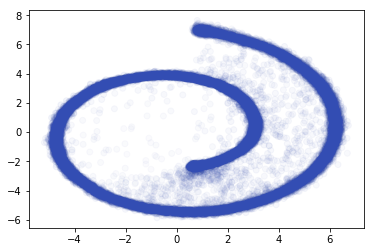

In [15]:
colors = np.zeros((400000,4))
colors[:,0] = 0.2
colors[:,1] = 0.3
colors[:,2] = 0.7
colors[:,3] = p*5e3

plt.scatter(y[::10,0], y[::10,2], color=colors[::10])
#plt.scatter(sw_all[::100,0], sw_all[::100,2], color='r')
plt.show()

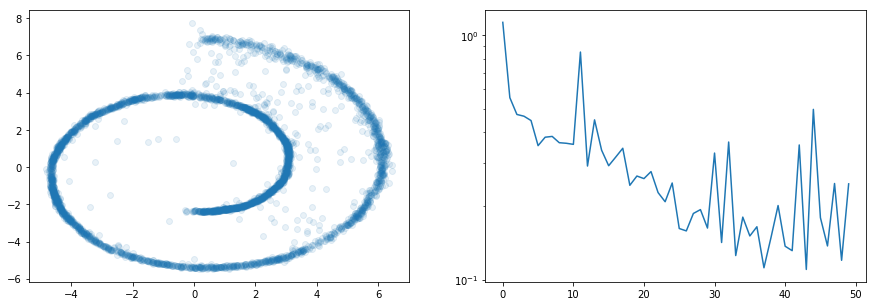

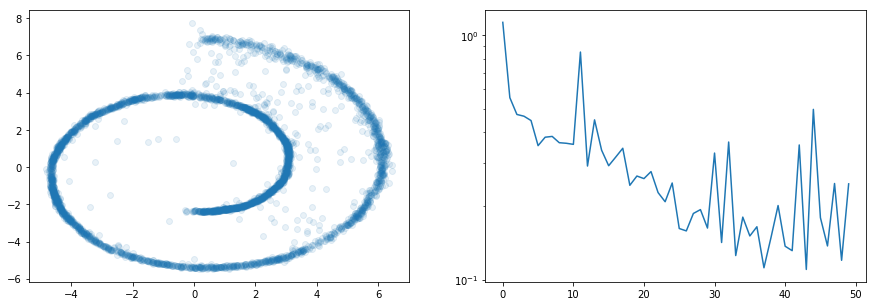

In [16]:
BS = 200

disc = Discriminator(width=32, d=d).cuda()
gen = Generator(width=32, d=d).cuda()

errs = []
KL = []
Fisher = []

x = tovar(sw_all[0:ndata])
xtrue = sw_all[ndata:]

idx = torch.arange(BS).long().cuda()

count = 0

for epoch in range(50):
    # Joint updates    
    for i in range(x.size(0)//BS):
        # Discriminator
        disc.zero_grad()

        xt = x[i*BS:i*BS+BS]
        xf = gen.forward(tovar(np.random.randn(BS, 16)))

        pto = disc.forward(xt, False)
        pfo = disc.forward(xf, False)
        pt = F.sigmoid(pto-torch.mean(pfo))
        pf = F.sigmoid(pfo-torch.mean(pto))

        loss = -torch.mean(torch.log(pt+1e-8)) - torch.mean(torch.log(1-pf+1e-8))
        loss.backward()

        disc.optim.step()

        # Generator
        gen.zero_grad()
        disc.zero_grad()

        for j in range(5):
            xt = x[i*BS:i*BS+BS]
            xf = gen.forward(tovar(np.random.randn(BS, 16)))

            pto = disc.forward(xt, j>0)
            pfo = disc.forward(xf, j>0)
            pt = F.sigmoid(pto-torch.mean(pfo))
            pf = F.sigmoid(pfo-torch.mean(pto))

            dloss = -torch.mean(torch.log(pt+1e-8)) - torch.mean(torch.log(1-pf+1e-8))
            disc.update(dloss)

        gloss = torch.mean(torch.log(pt+1e-8)) + torch.mean(torch.log(1-pf+1e-8))

        gloss.backward()
        gen.optim.step()

    disc.schedule.step()
    gen.schedule.step()

    if epoch%1 == 0:
        yy = np.zeros((0,sw_all.shape[1]))

        for i in range(4):
            y = gen.forward(tovar(np.random.randn(100000, 16)))
            y = y.cpu().detach().numpy()
            yy = np.concatenate([yy,y],axis=0)

        K, f = estimate_Nd_KL(xtrue,yy,np.ones(yy.shape[0]))
        Fisher.append(f)
        KL.append(K)

        plt.clf()
        plt.subplot(1,2,1)
        plt.scatter(yy[::100,0], yy[::100,2], alpha=0.1)
        
        plt.subplot(1,2,2)
        plt.plot(KL)
        plt.yscale("log")

        plt.gcf().set_size_inches((15,5))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)

In [17]:
# GAN
emp_kl, emp_f = estimate_Nd_KL(xtrue, sw_all[0:ndata], np.ones(ndata))
print(KL[-1], np.min(KL), emp_kl, Fisher[-1], np.min(Fisher), emp_f)

0.2463122787677756 0.11004097785468464 0.05358170566909279 0.6471552885774717 0.5067717425030628 0.12638762053085026


In [19]:
from sklearn.mixture import GaussianMixture

mixmodel = GaussianMixture(n_components=10)
mixmodel.fit(sw_all[0:ndata])
y_gmm, _ = mixmodel.sample(400000)

gmm_kl, gmm_f = estimate_Nd_KL(xtrue, y_gmm, np.ones(400000))
print(gmm_kl, gmm_f)

0.31252596434971325 1.2935867487807737


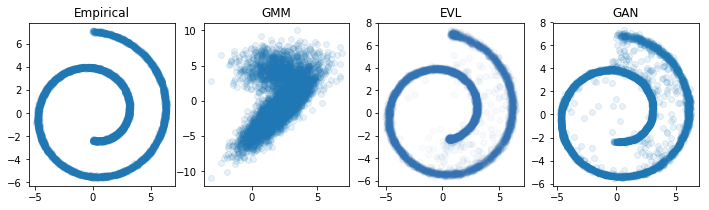

In [33]:
plt.subplot(1,4,1)
plt.scatter(sw_all[0:ndata:10,0], sw_all[0:ndata:10,2],alpha=0.1)
plt.title("Empirical")

plt.subplot(1,4,2)
plt.scatter(y_gmm[0:ndata:10,0], y_gmm[0:ndata:10,2],alpha=0.1)
plt.title("GMM")

plt.subplot(1,4,3)
colors = np.zeros((400000,4))
colors[:,0] = 0.2
colors[:,1] = 0.45
colors[:,2] = 0.7
colors[:,3] = p_evl*5e3

plt.scatter(y_evl[0:ndata:10,0], y_evl[0:ndata:10,2], color=colors[0:ndata:10])
plt.title("EVL")

plt.subplot(1,4,4)
plt.scatter(yy[0:ndata:10,0], yy[0:ndata:10,2], alpha=0.1)
plt.title("GAN")

plt.gcf().set_size_inches((12,3))
plt.savefig("swiss_roll.pdf")

In [35]:
np.savetxt("swissroll_evl_y.txt", y_evl)
np.savetxt("swissroll_evl_p.txt", p_evl)
np.savetxt("swissroll_gan_y.txt", yy)
np.savetxt("swissroll_gan_gmm.txt", y_gmm)